# Phase 4 Project: Time Series Modeling

##  Forecasting Real Estate Prices Using Time Series

* Student Name: Andrea Cabello

## I. Overview 

I have been hired by a real-estate investment firm to help them understand:
- How real estate prices have changed overtime and, 
- How to use this information to invest in areas with the most potential value increase.

To get me started I have been provided with a dataset from [Zillow Research](https://www.zillow.com/research/data/)

### Home values

Zillow Home Value Index (ZHVI): A smoothed, seasonally adjusted measure of the typical home value and market changes across a given region and housing type. It reflects the typical value for homes in the 35th to 65th percentile range. 

### Housing Bubble

* On December 30, 2008, the [Case–Shiller home price index](https://en.wikipedia.org/wiki/Case%E2%80%93Shiller_index) reported its largest price drop in its history. 
* The credit crisis resulting from the bursting of the housing bubble is an important cause of the Great Recession in the United States.


## II. Business Problem

* What are the top 5 best zip codes for us to invest in?

Let's begin by defining best: 
* What makes the value of a property go up?
* Law of Supply and Demand. e movements. Property values rise when a low supply of homes for sale meets strong buyer demand, as buyers compete in bidding wars to secure a home from the limited inventory.

* Return On Investment
* Average price over time
* Jobs Market
* Population growth
* Access to the city center or other relevant landmarks

## III. Cleaning and Obtaining Data

In [268]:
import pandas as pd
from pandas import Series
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [269]:
df = pd.read_csv('zillow_data.csv')

In [270]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [271]:
print('Total Zipcodes in DataFrame:', len(df))

Total Zipcodes in DataFrame: 14723


### Connecticut

* The firm is particularly interested in off-the-beaten-path areas of the North East Coast so I will focus my analysis on CT zipcodes.

In [272]:
## selecting ct zipcodes
df_ct = df.loc[df['State']== 'CT'].reset_index()
df_ct.drop(['index', 'RegionID', 'City', 'State'], axis=1, inplace=True)
df_ct.rename(columns={'RegionName': 'Zipcode'}, inplace=True)

In [273]:
df_ct.info()
df_ct.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Columns: 269 entries, Zipcode to 2018-04
dtypes: float64(219), int64(48), object(2)
memory usage: 260.7+ KB


,Zipcode,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,6010,Hartford,Hartford,113,120300.0,120000.0,119800.0,119400.0,119100.0,118800.0,...,188900,190000,191200,191800,192900,193600,194100,194900,195700,195700
1,6516,New Haven,New Haven,417,96500.0,96300.0,96100.0,95900.0,95600.0,95300.0,...,176600,176600,177300,177800,178200,178700,179700,180200,179700,178700
2,6511,New Haven,New Haven,546,89800.0,90000.0,90200.0,90300.0,90500.0,90700.0,...,181400,184000,187700,190100,193100,196300,198400,199100,199100,198300
3,6810,Stamford,Fairfield,685,151100.0,150700.0,150200.0,149700.0,149100.0,148600.0,...,252200,254800,258500,260900,262500,264000,265300,266100,266500,266500
4,6492,New Haven,New Haven,899,146800.0,146600.0,146300.0,146100.0,145900.0,145700.0,...,247600,248700,250200,251700,253100,254500,256100,257600,257600,256400


In [274]:
df_ct.Metro.unique()

array(['Hartford', 'New Haven', 'Stamford', 'New London', 'Torrington',
       'Worcester'], dtype=object)

In [275]:
print(f'Number of CT zipcodes: {len(df_ct)}')

Number of CT zipcodes: 124


### Reshape from Wide to Long Format

In [288]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode', 'Metro', 'CountyName', 'SizeRank'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [289]:
melted_df = melt_data(df_ct)

In [290]:
melted_df.isna().value_counts()

Zipcode  Metro  CountyName  SizeRank  Date   value
False    False  False       False     False  False    32860
dtype: int64

In [291]:
melted_df.info()
melted_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32860 entries, 0 to 32859
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Zipcode     32860 non-null  int64         
 1   Metro       32860 non-null  object        
 2   CountyName  32860 non-null  object        
 3   SizeRank    32860 non-null  int64         
 4   Date        32860 non-null  datetime64[ns]
 5   value       32860 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,Zipcode,Metro,CountyName,SizeRank,Date,value
0,6010,Hartford,Hartford,113,1996-04-01,120300.0
1,6516,New Haven,New Haven,417,1996-04-01,96500.0
2,6511,New Haven,New Haven,546,1996-04-01,89800.0
3,6810,Stamford,Fairfield,685,1996-04-01,151100.0
4,6492,New Haven,New Haven,899,1996-04-01,146800.0


In [292]:
melted_df.tail()

,Zipcode,Metro,CountyName,SizeRank,Date,value
32855,6794,Torrington,Litchfield,14096,2018-04-01,510500.0
32856,6793,Torrington,Litchfield,14356,2018-04-01,664400.0
32857,6027,Hartford,Hartford,14477,2018-04-01,252700.0
32858,6796,Torrington,Litchfield,14552,2018-04-01,418700.0
32859,6090,Hartford,Hartford,14655,2018-04-01,348200.0


In [293]:
# Make sure the data type of the 'Date' column is datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%m/%y')

# Set the 'Date' column as index
melted_df.set_index('Date', inplace=True)

In [294]:
melted_df.index

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=32860, freq=None)

* The data includes home values by month since April 1996 to April 2018. 
* Given the 2008 Housing Bubble precedent, I have decided to slice the dates and start my analysis at January 2009. 

In [295]:
melted_df = melted_df['2008-01-01':'2018-04-01']

### IV. EDA

In [296]:
melted_df.SizeRank.unique()

array([  113,   417,   546,   685,   899,  1145,  1332,  1362,  1599,
        1901,  2093,  2192,  2301,  2390,  2497,  3051,  3245,  3281,
        3368,  3532,  3565,  3581,  3696,  3760,  3778,  3789,  3978,
        4011,  4230,  4324,  4531,  4587,  4674,  4717,  5580,  5624,
        5687,  5756,  5852,  5870,  5941,  6037,  6063,  6084,  6176,
        6270,  6288,  6329,  6424,  6591,  6599,  6813,  6913,  7022,
        7031,  7144,  7259,  7317,  7382,  7471,  7496,  7595,  7704,
        7741,  7890,  8085,  8368,  8425,  8427,  8584,  8601,  8943,
        9032,  9136,  9160,  9275,  9298,  9457,  9577,  9681,  9715,
        9788,  9871,  9903,  9977, 10164, 10281, 10446, 10463, 10591,
       10651, 10663, 10786, 10809, 10893, 11245, 11629, 11907, 11929,
       12034, 12184, 12310, 12406, 12469, 12556, 12817, 12967, 13018,
       13065, 13214, 13215, 13266, 13465, 13564, 13567, 13646, 13714,
       13908, 13927, 14096, 14356, 14477, 14552, 14655])

* As per SizeRank values seen above, our data includes some very densely populated, somewhat populated, and also some of the least populated zipcodes in the US.

In [297]:
melted_df['value'].describe()

count    1.537600e+04
mean     2.802331e+05
std      1.840456e+05
min      8.010000e+04
25%      1.838000e+05
50%      2.419000e+05
75%      3.145250e+05
max      1.746000e+06
Name: value, dtype: float64

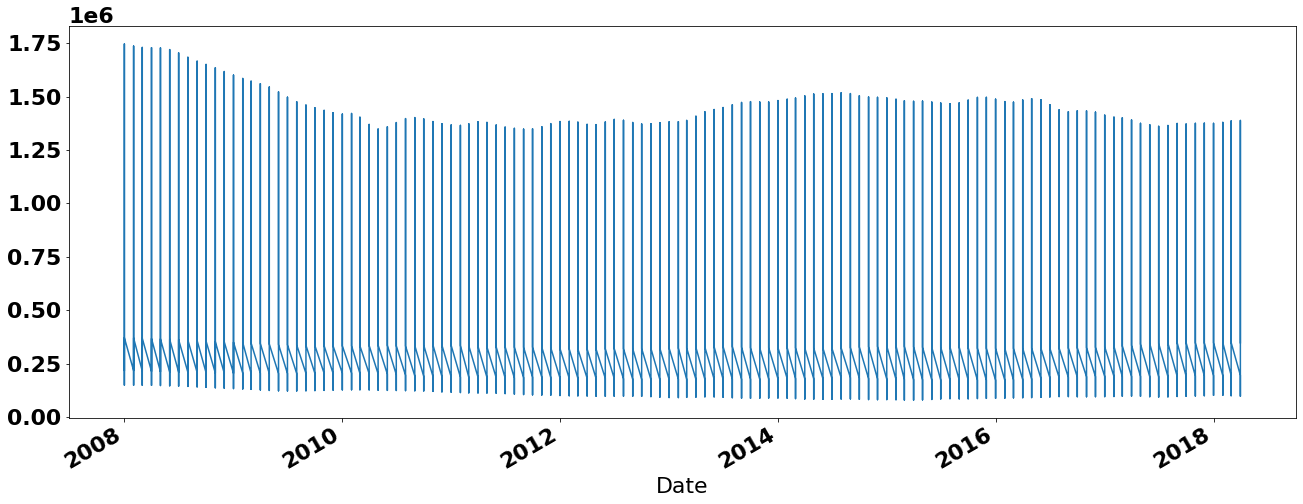

In [298]:
melted_df['value'].plot(figsize=(22,8))
plt.show()